In [1]:
import sys
sys.path.append("../")  # go to src directory

from src.utils import read_xlsx, create_logging, split_data, calculate_metrics

from src.modeling_manager.data_transformer import DataTransformer
from src.modeling_manager.modeling import select_model, train_best_model, evaluate_model, save_model
from sklearn.metrics import roc_auc_score, roc_curve

# classification algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

import matplotlib.pyplot as plt
%matplotlib inline

from src.modeling_manager.model_optimizer import Optimizer

In [2]:
create_logging()

In [3]:
# read the data 
path_to_train_data = "../data/train_file.xlsx"
df = read_xlsx(path_to_train_data)
df.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,previous,poutcome,y
0,49,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,0,nonexistent,no
1,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,1,failure,no
2,78,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,0,nonexistent,yes
3,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,0,nonexistent,no
4,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,0,nonexistent,no


#### Data preprocessing

**Removing some *features* from the dataset:**
* **duration**:
* This feature is highly correlated with the target variable "y", indicating that longer contact times are associated with a higher probability of subscribing to a fixed-term deposit. However, the duration of a contact is only known after the contact has been completed and the customer has made their decision. For predictive inference in production, where predictions need to be made before the contact occurs, including "duration" as a feature is impractical. Therefore, this feature should be excluded from the training data to ensure the model can be effectively used for real-time prediction.

* **day_of_week**:
* EDA has shown that this feature does not have a significant impact on the customer"s decision. Given its minimal impact, including it as a feature would not significantly improve the predictive performance of the model. Removing this feature from the training data helps to simplify the model and focus on more important features.
  
**Dealing with unknown categories:** 
* Categories labeled as "unknown" in features such as "job", "education", "default", "housing", and "loan" will be removed. These categories do not provide significant predictive value and their removal helps in cleaning the dataset.

**Combining basic education categories:**
* To simplify the dataset and improve model performance, all basic education categories ("basic.4y", "basic.6y", "basic.9y") are combined into a single, more general category "education.basic". This reduces the complexity of the education feature and helps the model generalize better by treating all levels of basic education as equivalent.

**Binning age:** 
* Given the wide distribution of ages in the dataset, this category will be split into four quantile-based bins. This approach groups ages into four equally sized bins, helping to normalize the distribution and potentially improve model performance by reducing the effect of outliers.

**Feature Encoding**:
* _**Ordinal features**_:
  * **age**: Encoded into quantile-based bins and then transformed using OrdinalEncoder.
  * **education**: Combined into "education.basic" and encoded using OrdinalEncoder.
  * **month**: Encoded using OrdinalEncoder to reflect the natural order of months.

* _**Categorical features**_:
    * **job**: Encoded using OneHotEncoder to create binary columns for each job category.
    * **default**, **loan**, **housing**, and for training data **y**: Encoded using binary mapping (e.g., "yes" = 1, "no" = 0).

In [4]:
# initialize Preprocessor
data_transformer = DataTransformer(df)

# preprocess some data
df = data_transformer.clean_and_transform()
df

,bins_age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,previous,poutcome,y
1,young_adult,entrepreneur,married,university.degree,0,0,0,1,nov,wed,2,1,failure,0
2,old_age,retired,married,education.basic,0,0,0,0,jul,mon,1,0,nonexistent,1
3,young_adult,admin.,married,university.degree,0,1,0,1,may,mon,2,0,nonexistent,0
4,middle_aged,retired,divorced,university.degree,0,0,0,0,jun,tue,2,0,nonexistent,0
5,young,admin.,single,university.degree,0,0,0,0,aug,wed,2,0,nonexistent,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32903,middle_aged,technician,married,education.basic,0,0,0,1,may,fri,5,0,nonexistent,0
32905,young,management,single,university.degree,0,0,0,0,nov,thu,5,1,failure,0
32906,young_adult,blue-collar,married,high.school,0,1,0,1,jun,mon,3,0,nonexistent,0
32907,young_adult,technician,married,professional.course,0,1,1,0,aug,mon,1,0,nonexistent,0


### Model selection

In [5]:
# define the models
models = {
    'LogisticRegression': LogisticRegression(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    # 'SVC': SVC(),
    'KNN': KNeighborsClassifier()
}

In [6]:
# Split the data
X_train, X_test, y_train, y_test = split_data(df, target='y')

#### Step 1: Transform data and evaluate models with cross-validation

In [7]:
eval_results = select_model(X_train, y_train, data_transformer, models)
eval_results

{'LogisticRegression': {'fit_time_mean': 0.1252307415008545,
  'accuracy_mean': 0.6783531074128752,
  'f1_mean': 0.33633178537005093,
  'roc_auc_mean': 0.7128640966862362},
 'DecisionTreeClassifier': {'fit_time_mean': 0.16545233726501465,
  'accuracy_mean': 0.8093429654316593,
  'f1_mean': 0.2934802036495722,
  'roc_auc_mean': 0.5947217044446904},
 'RandomForestClassifier': {'fit_time_mean': 2.0183427333831787,
  'accuracy_mean': 0.8600831651055734,
  'f1_mean': 0.32424774460390576,
  'roc_auc_mean': 0.716693063586052},
 'GradientBoostingClassifier': {'fit_time_mean': 2.758942461013794,
  'accuracy_mean': 0.874129062865285,
  'f1_mean': 0.378145642602765,
  'roc_auc_mean': 0.7538810850851151},
 'KNN': {'fit_time_mean': 0.06063799858093262,
  'accuracy_mean': 0.7096585286472324,
  'f1_mean': 0.31775968550023,
  'roc_auc_mean': 0.6596618015684946}}

In [8]:
# best model based on accuracy mean score
best_model_name = max(eval_results, key=lambda model: eval_results[model]["f1_mean"])
print(f"Best performed model: '{best_model_name}'") 

Best performed model: 'GradientBoostingClassifier'


#### Step 2: Train the model with the best score

In [9]:
%%time
model_pipeline = train_best_model(models,
                best_model_name,
                data_transformer,
                X_train,
                y_train)

CPU times: user 3.81 s, sys: 229 μs, total: 3.81 s
Wall time: 3.66 s


#### Step 3: Evaluate the model on the test data

In [10]:
y_pred = evaluate_model(model_pipeline, X_test, y_test)
metrics = calculate_metrics(y_test, y_pred)
metrics

2024-06-04 23:25:05,023 - src.modeling_manager.modeling - INFO - 
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      3995
           1       0.55      0.29      0.38       598

    accuracy                           0.88      4593
   macro avg       0.73      0.63      0.66      4593
weighted avg       0.86      0.88      0.86      4593



{'accuracy': 0.8769867189200958,
 'balanced_accuracy_score': 0.6285488549650273,
 'precision': 0.8556333313964178,
 'recall': 0.8769867189200958,
 'f1_score': 0.8601874287231749}

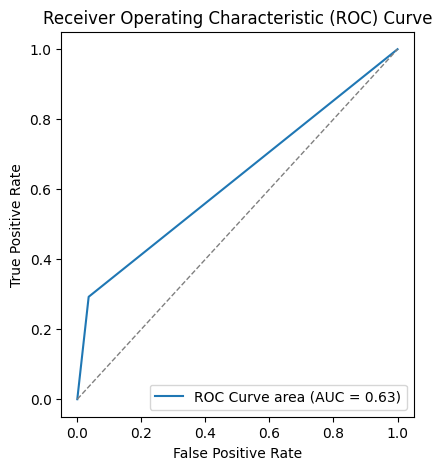

In [11]:
def show_roc_curve(y_test, y_pred):
    # Generate ROC curve
    false_positive_rate, true_positive_rate, _ = roc_curve(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred)

    # Plot ROC curve
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(false_positive_rate, true_positive_rate, label=f'ROC Curve area (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')

show_roc_curve(y_test, y_pred)

#### Step 4: Persist final model

In [12]:
save_model(model_pipeline)

2024-06-04 23:25:31,072 - src.modeling_manager.modeling - INFO - Final model saved to /home/nataliia/Workspaces/edu_private/user_subscription_prediction/model/trained_model_pipeline.pkl


#### Optional Step: Hyperparameter tuning with Optuna
_Hyperparameter tuning can take more than 15 minutes depending on the number of trials_

In [13]:
# define the models again so that they can be initialized with parameters
models = {
    'LogisticRegression': LogisticRegression,
    'DecisionTreeClassifier': DecisionTreeClassifier,
    'RandomForestClassifier': RandomForestClassifier,
    'GradientBoostingClassifier': GradientBoostingClassifier,
    'SVC': SVC,
    'KNN': KNeighborsClassifier
}

# predifine a set of hyperparameters for the models
models_params = {
    "LogisticRegression":  {
        'C': [0.01, 0.1], # Regularization parameter, controlling the trade-off between maximizing the margin and minimizing classification error
        'solver': ["liblinear", "newton-cholesky"],
        'random_state': 42
    },
    "DecisionTreeClassifier": {
        'splitter': ["best", "random"],
        'max_depth':  [1, 4],
        'class_weight': [None, "balanced"],
        'random_state': 42
    },
    "RandomForestClassifier": {
        'n_estimators': [100, 500],
        'max_depth': [1, 4],
        'random_state': 42
    },
    "GradientBoostingClassifier": {
        'learning_rate': [0.01, 0.1],
        'n_estimators': [100, 200],
        'max_depth': [3, 6],
        'random_state': 42
    },
    "SVC": {
        'C': [0.1, 1.5],
        'gamma': ["scale", "auto"],
        'kernel': ["linear", "poly", "rbf"],
        'random_state': 42
    },
    "KNN": {
        'n_neighbors': [2, 19],
        'weights': ['uniform', 'distance'],
        'metric': ['l2', 'manhattan', 'cosine']
    }
}

In [14]:
%%time
optimizer = Optimizer(best_model_name, models, models_params, n_trials=10)
tuned_model_pipeline = optimizer.hyperparameter_tuning(data_transformer, X_train, y_train)

# you can observe the optimization process starting optuna dashboard from notebooks/ directory using CLI:
# optuna-dashboard sqlite:///db.sqlite3

2024-06-04 23:25:38,902 - src.modeling_manager.model_optimizer - INFO - Initialized Optimizer with model: GradientBoostingClassifier
[I 2024-06-04 23:25:39,349] A new study created in RDB with name: no-name-8e1b4633-4c9c-492b-984f-381b7af45455
[I 2024-06-04 23:25:52,810] Trial 0 finished with value: 0.33793753165901264 and parameters: {'learning_rate': 0.07079574138506074, 'n_estimators': 191, 'max_depth': 6}. Best is trial 0 with value: 0.33793753165901264.
[I 2024-06-04 23:25:58,942] Trial 1 finished with value: 0.3771501169232769 and parameters: {'learning_rate': 0.0703421468373134, 'n_estimators': 145, 'max_depth': 3}. Best is trial 1 with value: 0.3771501169232769.
[I 2024-06-04 23:26:05,115] Trial 2 finished with value: 0.3799407517636214 and parameters: {'learning_rate': 0.011836111344364056, 'n_estimators': 149, 'max_depth': 3}. Best is trial 2 with value: 0.3799407517636214.
[I 2024-06-04 23:26:16,936] Trial 3 finished with value: 0.35289987628181124 and parameters: {'learning

CPU times: user 11.4 s, sys: 1.16 s, total: 12.6 s
Wall time: 1min 31s


In [15]:
# evaluate the tuned model
y_pred = evaluate_model(tuned_model_pipeline, X_test, y_test)
metrics = calculate_metrics(y_test, y_pred)
metrics

2024-06-04 23:27:10,714 - src.modeling_manager.modeling - INFO - 
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      3995
           1       0.51      0.36      0.42       598

    accuracy                           0.87      4593
   macro avg       0.71      0.65      0.67      4593
weighted avg       0.86      0.87      0.86      4593



{'accuracy': 0.8708904855214457,
 'balanced_accuracy_score': 0.6534830327206667,
 'precision': 0.8557401959493759,
 'recall': 0.8708904855214457,
 'f1_score': 0.8613417220228541}

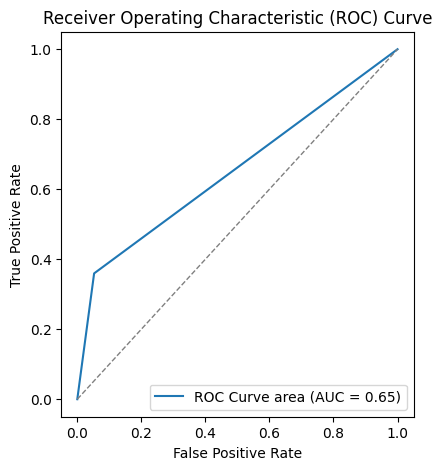

In [16]:
show_roc_curve(y_test, y_pred)

In [17]:
# persist tuned model
save_model(tuned_model_pipeline, file_name="trained_model_pipeline_tuned.pkl")

2024-06-04 23:27:10,875 - src.modeling_manager.modeling - INFO - Final model saved to /home/nataliia/Workspaces/edu_private/user_subscription_prediction/model/trained_model_pipeline_tuned.pkl
